In [1]:
import cv2
import pytesseract
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as inter


In [2]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\ARJUN B\AppData\Local\Tesseract-OCR\tesseract.exe'


In [3]:
class preprocessing:
    def __init__(self):
        self.pic=glob('images/*.jpg')
        self.img=cv2.imread(self.pic[0])
        self.name=self.img
        
    def img_size(self):
        print(self.img.shape)
        
    def view(self):
        plt.imshow(self.img)
        
    def view_name(self):
        plt.imshow(self.name)
    
    def grey_scale(self,img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.multiply(gray, 1.5)
        return gray
        
    def aspect_ratio_resize(self, width=None, height=None, inter=cv2.INTER_AREA):
        dim = None
        (h, w) = self.img.shape[:2]

        if width is None and height is None:
            return self.img

        if width is None:
            r = height / float(h)
            dim = (int(w * r), height)
        
        else:
            r = width / float(w)
            dim = (width, int(h * r))

        self.img= cv2.resize(self.img, dim, interpolation=inter)
    
    def correct_skew(self, delta=1, limit=5):
        def determine_score(arr, angle):
            data = inter.rotate(arr, angle, reshape=False, order=0)
            histogram = np.sum(data, axis=1, dtype=float)
            score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
            return histogram, score

        gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

        scores = []
        angles = np.arange(-limit, limit + delta, delta)
        for angle in angles:
            histogram, score = determine_score(thresh, angle)
            scores.append(score)

        best_angle = angles[scores.index(max(scores))]

        (h, w) = self.img.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
        rotated = cv2.warpAffine(self.img, M, (w, h), flags=cv2.INTER_CUBIC, \
              borderMode=cv2.BORDER_REPLICATE)
        
        self.img=rotated
        return best_angle
    
    def cro(self):
        roi=cv2.selectROI(self.img)
        name=self.img[int(roi[1]):int(roi[1]+roi[3]),int(roi[0]):int(roi[0]+roi[2])]
        self.name=name
        self.view_name()
        
    def bgremove(self):
        gray=self.grey_scale(self.name)
        blured1 = cv2.medianBlur(gray,3)
        blured2 = cv2.medianBlur(gray,51)
        divided = np.ma.divide(blured1, blured2).data
        normed = np.uint8(255*divided/divided.max())
       
        myimage_grey  =normed
 
        ret,baseline = cv2.threshold(myimage_grey,127,255,cv2.THRESH_TRUNC)
 
        ret,background = cv2.threshold(baseline,126,255,cv2.THRESH_BINARY)
 
        ret,foreground = cv2.threshold(baseline,126,255,cv2.THRESH_BINARY_INV)
 
        foreground = cv2.bitwise_and(self.name,self.name, mask=foreground)  # Update foreground with bitwise_and to extract real foreground
        background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)
 
        self.name = background+foreground

        self.view_name()



        
    def otsu_algo(self):
        gray=self.grey_scale(self.name)
        th, threshed = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)
        self.name=threshed
        self.view_name()
        
    
    def extract_txt(self):
        return pytesseract.image_to_string(self.name,config='--oem 1 --psm 6')
        
    
obj=preprocessing()


In [4]:
obj.img_size()

(854, 1280, 3)


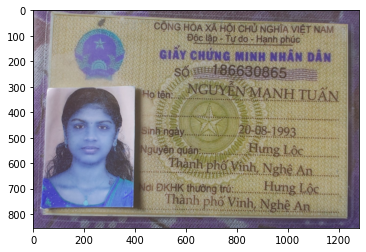

In [5]:
obj.view()

In [6]:
obj.aspect_ratio_resize(800)

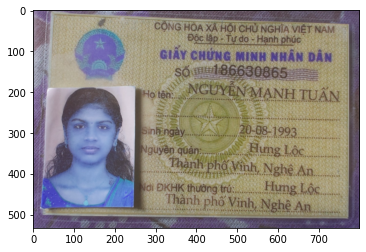

In [7]:
obj.view()

C:\Users\ARJUN B\AppData\Local\Temp\ipykernel_5040\2051030174.py:40: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


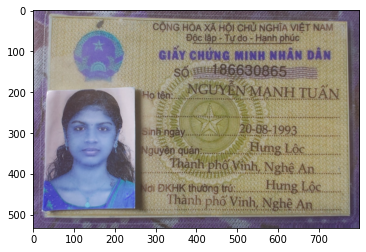

In [8]:
while True:
    angle= obj.correct_skew()
    if angle==0:
        break
obj.view()

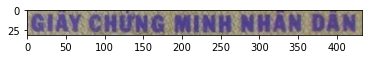

In [9]:
obj.cro()

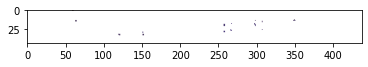

In [10]:
obj.bgremove()

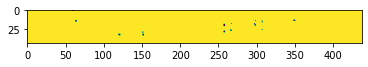

In [11]:
obj.otsu_algo()

In [10]:
obj.extract_txt()

'GIAY CHUNG MINH NHAN DAN\n'

In [17]:
pytesseract.image_to_string(obj.name,config='--oem 1 --psm 6')

'GIAY CHUNG MINH NHAN DAN\n'

: 